In [ ]:
!pip install scikit-optimize
!git clone https://github.com/modestyachts/cifar-10.2.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 757.6 kB/s eta 0:00:00
Cloning into 'cifar-10.2'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from time import perf_counter
import random
import os
from google.colab import drive
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential, load_model
from keras.backend import clear_session
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Resizing, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, KLDivergence 
from keras.utils import to_categorical
from tensorflow.keras.applications import inception_v3, vgg16, ResNet50, resnet50  
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical, LogN
from skopt.plots import plot_convergence
from skopt import callbacks
from skopt.callbacks import CheckpointSaver


drive.mount('/content/drive')
gdrive_dir = '/content/drive/My Drive/CI/Project/logs/'  # --change to your path--
assert os.path.exists(gdrive_dir)

tf.random.set_seed(420)
tf.__version__

Mounted at /content/drive


'2.9.2'

In [ ]:
# # Cifar 10
# from tensorflow.keras.datasets import cifar10
# (x_train2, y_train2), (x_test2, y_test2) = cifar10.load_data()
# x_train = x_train2.astype("float32") / 255
# x_test = x_test2.astype("float32") / 255
# # One-Hot encoding
# y_train = to_categorical(y_train2, num_classes=10)
# y_test = to_categorical(y_test2, num_classes=10)

In [ ]:
# Cifar 10.2 
def preprocessCIFAR10_2():
  train_data = np.load('cifar-10.2/cifar102_train.npz')
  test_data = np.load('cifar-10.2/cifar102_test.npz')
  label_names = test_data['label_names']

  x_train = train_data['images']
  y_train = train_data['labels']

  indexes_test = np.array(range(len(x_train)))
  random.shuffle(indexes_test)
  x_train = x_train[indexes_test]
  y_train1 = y_train[indexes_test]

  x_test = test_data['images']
  y_test = test_data['labels']

  # One-Hot encoding
  y_train = to_categorical(y_train1, num_classes=10)
  y_test = to_categorical(y_test, num_classes=10)
  return(x_train, y_train, x_test, y_test, label_names)

In [ ]:
def print_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def print_report(model, x, y, labels):

  # Prediction
  predictions = model.predict(x)
  # Select for each observation the highest probability
  predictions = np.argmax(predictions, axis=1)
  real = np.argmax(y, axis=1)
  # Confusion matrix
  confusionMatrix = confusion_matrix(real, predictions)
  print(pd.DataFrame(confusionMatrix, columns=labels, index=labels))

  # Classification Report
  print(classification_report(real, predictions, target_names=labels,))


In [ ]:
def create_model(name, nlayers, units, dropout_rate):

  if name == 'resNet50':
    base_model = ResNet50
  elif name == 'inceptionv3':
    base_model = inception_v3.InceptionV3
  elif name == 'vgg16':
    base_model = vgg16.VGG16

  # Defining the model
  base_model = base_model(
      include_top=False,
      weights='imagenet',
      input_shape = (299, 299, 3),
      classes=10
  )

  # Resize + Base Model
  final_model = Sequential()
  final_model.add(Resizing(299, 299))
  final_model.add(base_model)

  # Define new layers
  new_layers = Sequential()
  new_layers.add(GlobalAveragePooling2D(name='avg_pool'))
  for i in range(nlayers):
    u = units * 2 ** -i
    new_layers.add(Dense(u, activation='relu'))
    new_layers.add(Dropout(dropout_rate))
  new_layers.add(Dense(10, activation='softmax'))

  # Joining both models
  final_model.add(new_layers)
  
  return final_model, base_model, new_layers

In [ ]:
def train_model(params, model_name, nlayers, reuse_params=None, eval=False):
  clear_session()
  t_start = perf_counter()

  epochs1 = 100
  epochs2 = 100
  patience = 5

  if reuse_params:
    units, dropout = params
    lr, batch_size, loss = reuse_params
  else:
    units, dropout, lr, batch_size, loss = params

  batch_size = 2**batch_size  # use as exponent

  print(f'\nParameter:\n units:{units} dropout:{dropout:.4f} lr:{lr:.4f} batch_size:{batch_size} loss:{loss}\n')

  # Define all the parameters
  x_train, y_train, x_test, y_test, label_names = preprocessCIFAR10_2()

  # preprocess data
  if model_name == 'resNet50':
    x_tr = resnet50.preprocess_input(x_train)
    x_te = resnet50.preprocess_input(x_test)
  elif model_name == 'inceptionv3':
    x_tr = inception_v3.preprocess_input(x_train)
    x_te = inception_v3.preprocess_input(x_test)
  elif model_name == 'vgg16':
    x_tr = vgg16.preprocess_input(x_train)
    x_te = vgg16.preprocess_input(x_test)
  else:
    raise ValueError('unknown model_name (typo?):', model_name)

  # create model
  model, base_model, new_layers = create_model(model_name, nlayers, units, dropout)

  # Freezing the model
  base_model.trainable = False
  new_layers.trainable = True

  # train
  es = EarlyStopping(patience=patience,  restore_best_weights=True, monitor="val_accuracy", baseline=0.5)
  model.compile(optimizer=Adam(learning_rate=lr, amsgrad=True), loss=loss(), metrics=['accuracy'])
  history = model.fit(x_tr, y_train, batch_size=batch_size, epochs=epochs1, validation_split=0.1, callbacks=[es], verbose=2)
  t_end1 = perf_counter()

  # save & evaluate
  if eval:
    model.save(f'{model_name}_transformed.h5')
    print(f"\nResults for the training of top layer of {model_name}:\n")
    print(f'time: {t_end1 - t_start:.4f}secs')
    model.summary()
    print_report(model, x_te, y_test, label_names)
    print_learning_curves(history)

  # Freeze all the layers before the `fine_tune_at` layer
  new_layers.trainable = True
  base_model.trainable = True
  fine_tune_at = len(base_model.layers) // 2
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # train
  model.compile(optimizer=Adam(learning_rate=lr/10, amsgrad=True), loss=loss(), metrics=['accuracy'])
  history = model.fit(x_tr, y_train, batch_size=batch_size, epochs=epochs2, validation_split=0.1, callbacks=[es], verbose=2)
  t_end2 = perf_counter()

  # save & evaluate
  if eval:
    model.save(f'{model_name}_tuned.h5')
    print(f"\nResults for the fine tunig of top layer of {model_name}:\n")
    print(f'time: {t_end2 - t_start:.4f}secs')
    print_report(model, x_te, y_test, label_names)
    print_learning_curves(history)

  # result
  acc = max(history.history['val_accuracy'])
  print(f'Final accuracy for model: {acc}\n')
    
  return -1 * acc # score for minimization

In [ ]:
def optimize_params(model_name, nlayers, reuse_params=None, opti_iter=10):

  space = [
    Integer(16, 512, prior='log-uniform', base=2,  name='units'),
    Real(0.0, 0.6,   prior='uniform',     base=10, name='dropout_rate'),
    Real(1e-5, 1e-3, prior='log-uniform', base=10, name='learning_rate'),  # reuse
    Integer(4, 6,    prior='uniform',     base=10, name='batch_size'),     # reuse
    Categorical([CategoricalCrossentropy, KLDivergence], name='loss')      # reuse
  ]

  if reuse_params:  # remove lr, bs, loss from space
    space = space[:2]

  fct = lambda params: train_model(params, model_name, nlayers, reuse_params)
  cp_fname = f"{gdrive_dir}bo_checkpoint_{model_name}_layers{nlayers}.pkl"

  # file already exists - optimization has been interrupted
  if os.path.exists(cp_fname):
    res = skopt.load(cp_fname)
    x0 = res.x_iters
    y0 = res.func_vals
    init_points=0
    opti_iter -= len(x0)
    print("imported iterations", len(x0))
    print("imported parameters", x0)
    print("imported values", y0)
    
    if opti_iter <= 0:
      # evaluate
      print(f"\nResults for the Baysian Optimization for {model_name}:")
      print('best parameters: ', res.x)
      print('best accuracy: ', -res.fun)
      plot_convergence(res)
      plt.show()
      return res

  else:
    x0=None
    y0=None
    init_points=4

  res = gp_minimize(fct,                          # the function to minimize
                    space,                        # the bounds on each dimension of x
                    n_initial_points=init_points, # initial random points
                    x0=x0,                        # Initial input points
                    y0=y0,                        # evaluation of x0
                    n_calls=opti_iter,            # the number of evaluations of f
                    callback=[CheckpointSaver(cp_fname, compress=9)],
                    random_state=420)             # the random seed

  # evaluate
  print(f"\nResults for the Baysian Optimization for {model_name}:")
  print('best parameters: ', res.x)
  print('best accuracy: ', -res.fun)
  plot_convergence(res)
  plt.plot()

  return res

imported iterations 35
imported parameters [[93, 0.09633472532175001, 0.0005639158638440289, 4, <class 'keras.losses.CategoricalCrossentropy'>], [387, 0.032494587008078064, 1.9169056612087216e-05, 5, <class 'keras.losses.CategoricalCrossentropy'>], [395, 0.035645155178601416, 1.4665795838089383e-05, 6, <class 'keras.losses.KLDivergence'>], [392, 0.5332384276470826, 0.001, 6, <class 'keras.losses.CategoricalCrossentropy'>], [63, 0.545081183737233, 0.00022659618705795953, 4, <class 'keras.losses.CategoricalCrossentropy'>], [46, 0.0, 0.001, 4, <class 'keras.losses.KLDivergence'>], [68, 0.5074244380069644, 0.00040589286149758945, 6, <class 'keras.losses.KLDivergence'>], [27, 0.1314230294581423, 0.000108673530817774, 4, <class 'keras.losses.KLDivergence'>], [463, 0.4038235518514949, 0.0009985235832606417, 6, <class 'keras.losses.CategoricalCrossentropy'>], [87, 0.31038235994387736, 0.0005241366205123941, 5, <class 'keras.losses.CategoricalCrossentropy'>], [19, 0.08890644819602829, 1.1183315

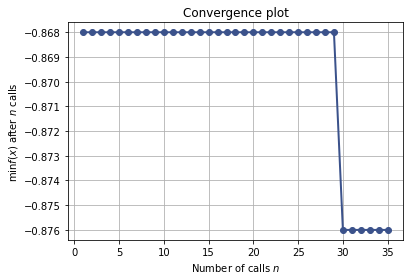


_________________________
Number of layers: 2
imported iterations 15
imported parameters [[93, 0.09633472532175001], [333, 0.06489274740889585], [59, 0.5517270476483646], [19, 0.08478022199727857], [16, 0.0], [16, 0.33990701199175083], [16, 0.0], [502, 0.0], [512, 0.0], [475, 0.1737165708964413], [16, 0.20889486584505718], [76, 0.0], [512, 0.6], [512, 0.39351039901325263], [55, 0.0]]
imported values [-0.81199998 -0.81800002 -0.741      -0.82700002 -0.85799998 -0.671
 -0.81699997 -0.84799999 -0.83099997 -0.83200002 -0.71600002 -0.84899998
 -0.82700002 -0.82999998 -0.87400001]

Results for the Baysian Optimization for resNet50:
best parameters:  [55, 0.0]
best accuracy:  0.8740000128746033


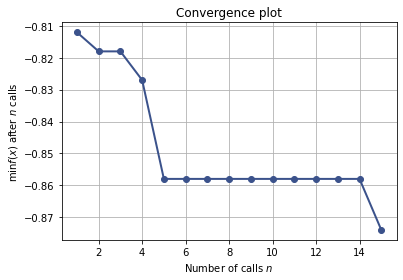


Final number of layers: 1

Parameter:
 units:178 dropout:0.0000 lr:0.0010 batch_size:64 loss:<class 'keras.losses.CategoricalCrossentropy'>

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/100
141/141 - 66s - loss: 0.9569 - accuracy: 0.6614 - val_loss: 0.7804 - val_accuracy: 0.7280 - 66s/epoch - 470ms/step
Epoch 2/100
141/141 - 56s - loss: 0.6241 - accuracy: 0.7812 - val_loss: 0.7936 - val_accuracy: 0.7200 - 56s/epoch - 397ms/step
Epoch 3/100
141/141 - 56s - loss: 0.5144 - accuracy: 0.8169 - val_loss: 0.7971 - val_accuracy: 0.7160 - 56s/epoch - 398ms/step
Epoch 4/100
141/141 - 57s - loss: 0.4546 - accuracy: 0.8400 - val_loss: 0.6822 - val_accuracy: 0.7570 - 57s/epoch - 406ms/step
Epoch 5/100
141/141 - 57s - loss: 0.3816 - accuracy: 0.8718 - val_loss: 0.7832 - val_accuracy: 0.7460 - 57s/epoch - 404ms/step
Epoch 6/100
141/141 - 57s - loss: 0.3340 - accuracy: 0.8859 - val_loss: 0.7268 - val_accuracy: 0.7630 - 57s/epoch - 405ms/step
Epoch 7/100
141/141 - 57s - los

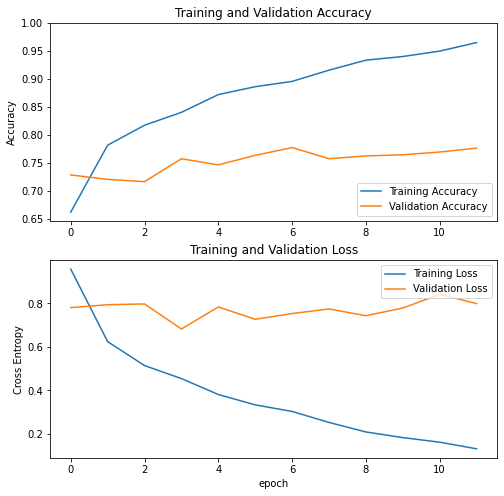

Epoch 1/100
141/141 - 108s - loss: 0.5033 - accuracy: 0.8330 - val_loss: 0.7964 - val_accuracy: 0.7790 - 108s/epoch - 767ms/step
Epoch 2/100
141/141 - 99s - loss: 0.0604 - accuracy: 0.9846 - val_loss: 0.6323 - val_accuracy: 0.8130 - 99s/epoch - 705ms/step
Epoch 3/100
141/141 - 99s - loss: 0.0118 - accuracy: 0.9984 - val_loss: 0.6070 - val_accuracy: 0.8330 - 99s/epoch - 705ms/step
Epoch 4/100
141/141 - 99s - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.5902 - val_accuracy: 0.8370 - 99s/epoch - 704ms/step
Epoch 5/100
141/141 - 100s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5922 - val_accuracy: 0.8520 - 100s/epoch - 708ms/step
Epoch 6/100
141/141 - 99s - loss: 9.5076e-04 - accuracy: 1.0000 - val_loss: 0.5921 - val_accuracy: 0.8580 - 99s/epoch - 704ms/step
Epoch 7/100
141/141 - 99s - loss: 6.1041e-04 - accuracy: 1.0000 - val_loss: 0.6044 - val_accuracy: 0.8560 - 99s/epoch - 702ms/step
Epoch 8/100
141/141 - 99s - loss: 5.0793e-04 - accuracy: 1.0000 - val_loss: 0.6065 - val_accuracy: 

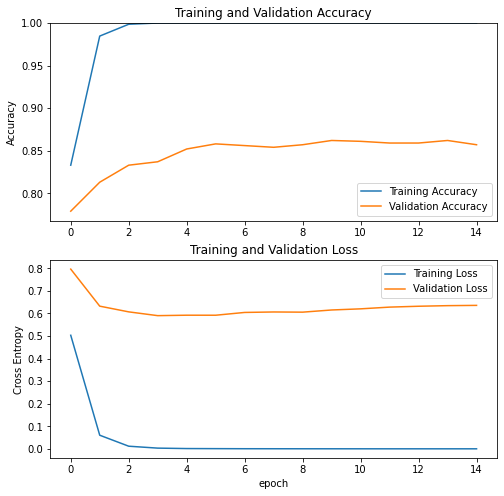

Final accuracy for model: 0.8619999885559082



In [ ]:
# optimize with one layers
resNet50_res = optimize_params("resNet50", nlayers=1, opti_iter=35)
lr_resNet50, bs_resNet50, loss_resNet50 = resNet50_res.x[2:]  # reuse
acc = -resNet50_res.fun

# optimize next layers
for layer in range(2, 5):
  print('\n_________________________\nNumber of layers:', layer)
  new_resNet50_res = optimize_params("resNet50", 
                                     nlayers=layer, 
                                     reuse_params=[lr_resNet50, bs_resNet50, loss_resNet50], 
                                     opti_iter=15)
  new_acc = -new_resNet50_res.fun

  if new_acc < acc: break
  acc = new_acc
  resNet50_res = new_resNet50_res

final_nlayers = layer-1
print('\nFinal number of layers:', final_nlayers)

# evaluate
# train_model(params, model_name, nlayers, reuse_params=None, eval=False):
train_model(resNet50_res.x[:2], 
            "resNet50", 
            nlayers=final_nlayers, 
            reuse_params=[lr_resNet50, bs_resNet50, loss_resNet50], 
            eval=True)
final_resNet50 = load_model(f'resNet50_tuned.h5')
final_resNet50.save(f'{gdrive_dir}final_resNet50.h5')

In [ ]:
# # optimize layers=1
# inceptionv3_res = optimize_params("inceptionv3", nlayers=1, opti_iter=20)
# units_inceptionv3 = inceptionv3_res.x[0]
# acc = -inceptionv3_res.fun

# # optimize next layers
# for layer in range(2, 5):
#   print('\n_________________________\nNumber of layers:', layer)
#   new_inceptionv3_res = optimize_params("inceptionv3", nlayers=layer, units=units_inceptionv3)
#   new_acc = -inceptionv3_res.fun

#   if new_acc < acc: break
#   acc = new_acc
#   inceptionv3_res = new_inceptionv3_res

# final_nlayers = layer-1
# print('\nFinal number of layers:',final_nlayers)

# # evaluate & save in drive
# train_model(inceptionv3_res.x, "inceptionv3", nlayers=final_nlayers, units=units_inceptionv3, eval=True)
# final_inceptionv3 = load_model(f'inceptionv3_tuned.h5')
# final_inceptionv3.save(f'{gdrive_dir}final_inceptionv3.h5')

In [ ]:
# # optimize layers=1
# vgg16_res = optimize_params("vgg16", nlayers=1, opti_iter=20)
# units_vgg16 = vgg16_res.x[0]
# acc = -vgg16_res.fun

# # optimize next layers
# for layer in range(2, 5):
#   print('\n_________________________\nNumber of layers:', layer)
#   new_vgg16_res = optimize_params("vgg16", nlayers=layer, units=units_vgg16)
#   new_acc = -vgg16_res.fun

#   if new_acc < acc: break
#   acc = new_acc
#   vgg16_res = new_vgg16_res

# final_nlayers = layer-1
# print('\nFinal number of layers:',final_nlayers)

# #save in g-drive
# train_model(vgg16_res.x, "vgg16", nlayers=final_nlayers, units=units_vgg16, eval=True)
# final_vgg16 = load_model(f'vgg16_tuned.h5')
# final_vgg16.save(f'{gdrive_dir}final_vgg16.h5')